In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import matplotlib.ticker as tick
import stylecloud
import numpy as np

from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from torchmetrics import (
    PrecisionRecallCurve
)

/home/yassin/Projects/Masters/code/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with wandb.init() as run:
    dan = run.use_artifact("yass/clinical-longformer-test/run-iazv60p9-test_table:v0").get("test_table")
    lstm = run.use_artifact("yass/clinical-longformer-test/run-1y0wf6kl-lstm_table:v0").get("lstm_table")
    bert = run.use_artifact('yass/clinical-longformer-test/run-ute5a294-bert_table:v0').get("bert_table")
    longf_1024 = run.use_artifact('yass/clinical-longformer-test/run-30hp2c54-longf1024_table:v0').get("longf-1024_table")
    longf_2048 = run.use_artifact('yass/clinical-longformer-test/run-2c9lt878-longf2048_table:v0').get("longf-2048_table")
    longf_4096 = run.use_artifact('yass/clinical-longformer-test/run-2nflkt4r-test_table:v0').get("test_table")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yass. Use `wandb login --relogin` to force relogin


In [3]:
df_dan = pd.DataFrame(dan.data, columns=dan.columns)
df_lstm = pd.DataFrame(lstm.data, columns=lstm.columns)
df_bert = pd.DataFrame(bert.data, columns=bert.columns)
df_longf_1024  = pd.DataFrame(longf_1024.data, columns=longf_1024.columns)
df_longf_2048  = pd.DataFrame(longf_2048.data, columns=longf_2048.columns)
df_longf_4096  = pd.DataFrame(longf_4096.data, columns=longf_4096.columns)

df_dan = df_dan.rename(columns={"pred": "p_readmit"})
df_lstm = df_lstm.rename(columns={"pred": "p_readmit"})
df_longf_4096 = df_longf_4096.rename(columns={"pred_y": "p_readmit"})

dfs = [
    ("DAN", df_dan.groupby("hadm_id").first().reset_index()),
    ("LSTM", df_lstm.groupby("hadm_id").first().reset_index()),
    ("BERT", df_bert.groupby("hadm_id").first().reset_index()),
    ("Longformer 1K", df_longf_1024.groupby("hadm_id").first().reset_index()),
    ("Longformer 2K", df_longf_2048.groupby("hadm_id").first().reset_index()),
    ("Longformer 4K", df_longf_4096.groupby("hadm_id").first().reset_index())
]

In [4]:
import torch

pr_curve = PrecisionRecallCurve(pos_label=1)

# BERT
bert = dfs[2][1]
preds = torch.tensor(bert["p_readmit"])
target = torch.tensor(bert["target"])
precision, recall, thresholds = pr_curve(preds, target)
# recall

# SOrt first, average
recall[torch.where(precision >= 0.699)[0]]




/home/yassin/Projects/Masters/code/.venv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor([0.0277, 0.0277, 0.0237, 0.0198, 0.0000])

In [5]:
TEXT_SIZE = 800

# Precision-Recall Curve


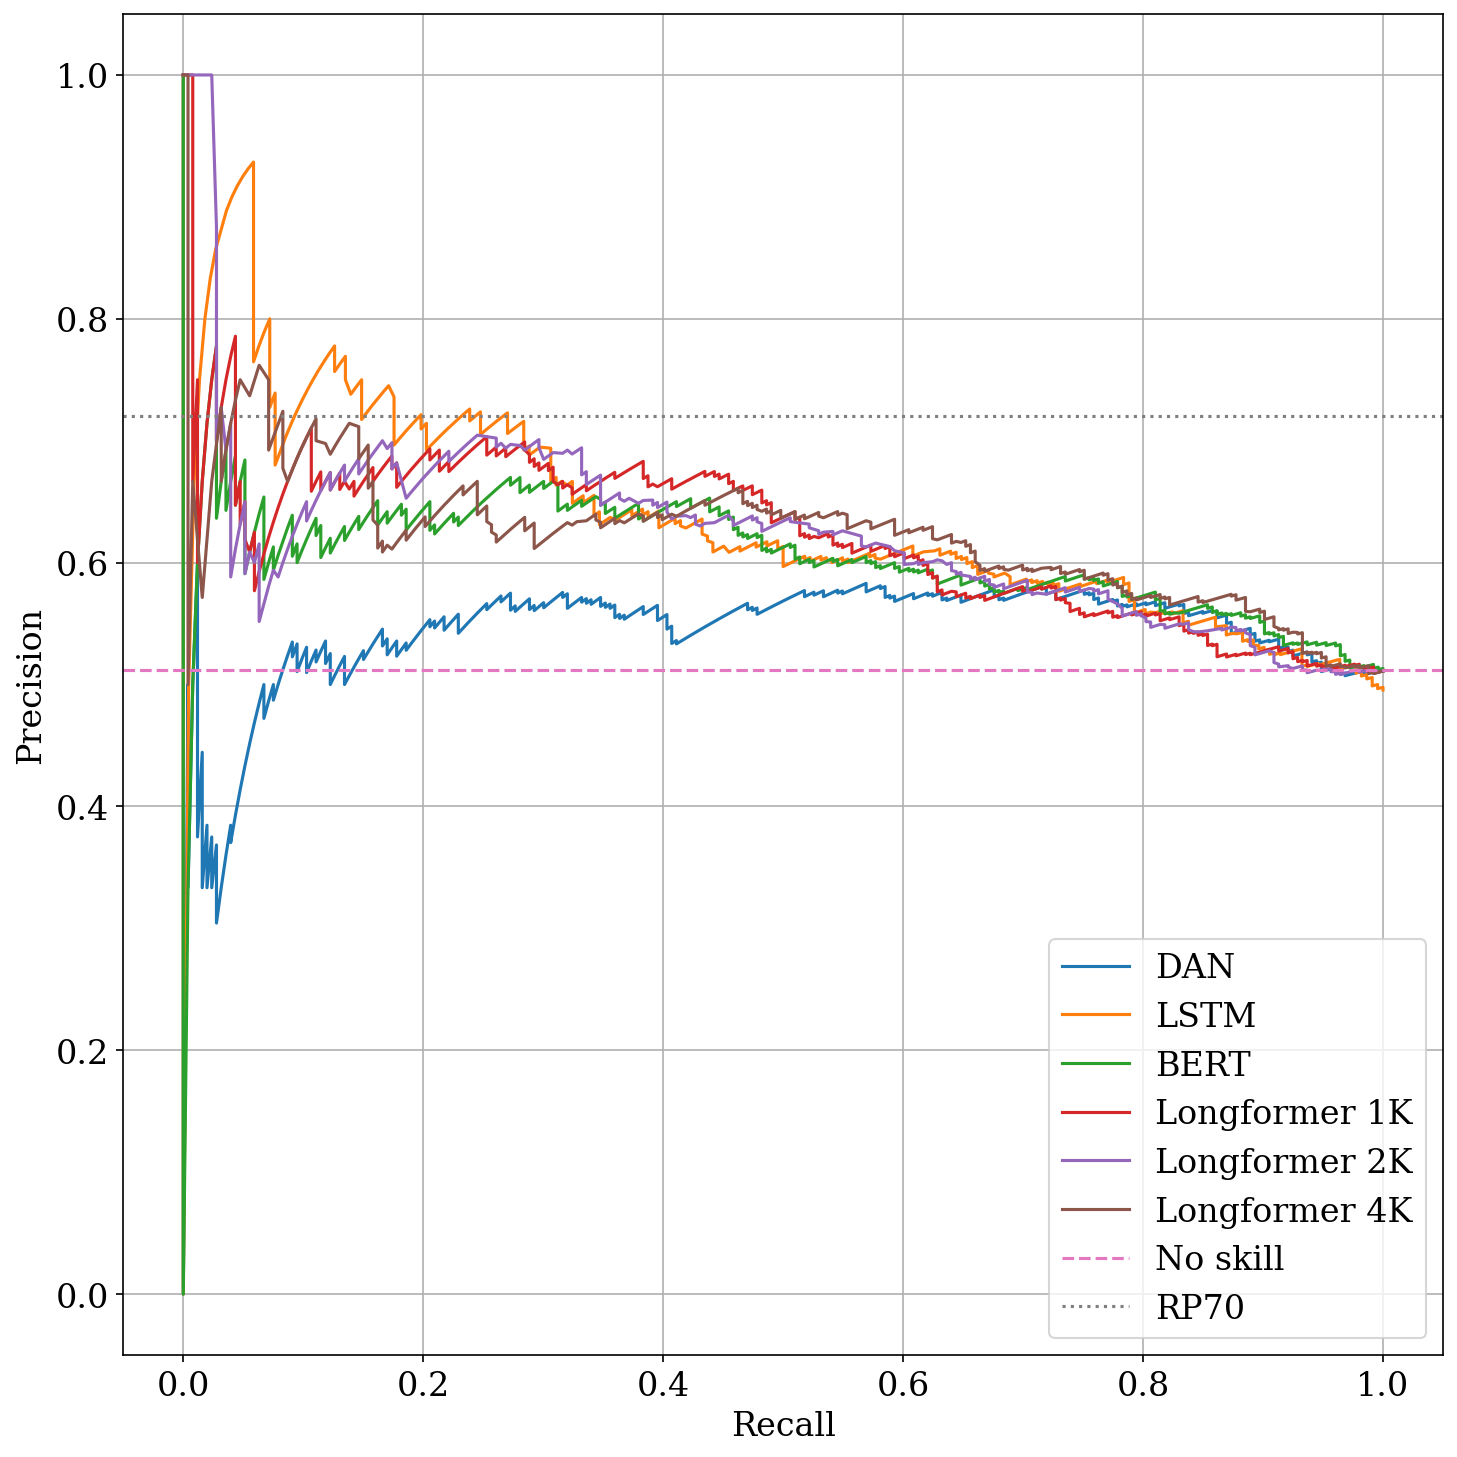

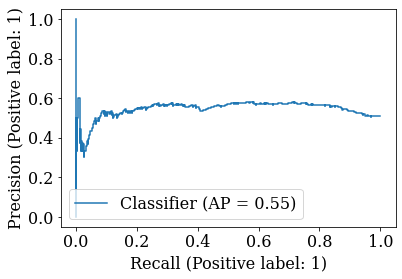

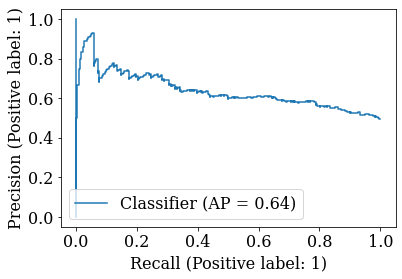

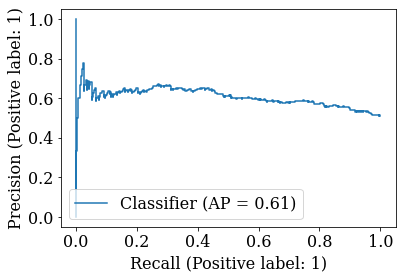

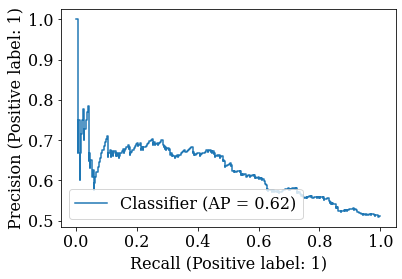

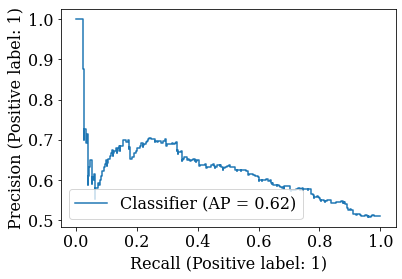

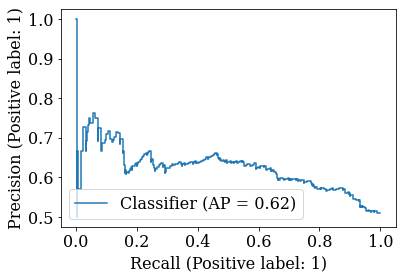

In [6]:
plt.rc('font', size=16, family=["Serif", "Palatino"])

df = dfs[0][1]
positives = len(df[df["target"] == 1]) / len(df)

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
for (name, df) in dfs:
    display = PrecisionRecallDisplay.from_predictions(df.target, df.p_readmit)
    display.plot(ax=ax, name=name, drawstyle="default", label=name)

ax.plot([0, 1], [positives] * 2, linestyle='--', label="No skill", transform=ax.transAxes)
ax.plot([0, 1], [0.7] * 2, linestyle=':', label="RP70", transform=ax.transAxes)
ax.set(xlabel="Recall", ylabel="Precision")
ax.legend(loc="lower right")
ax.grid(True)
fig.tight_layout()


# ROC Curve

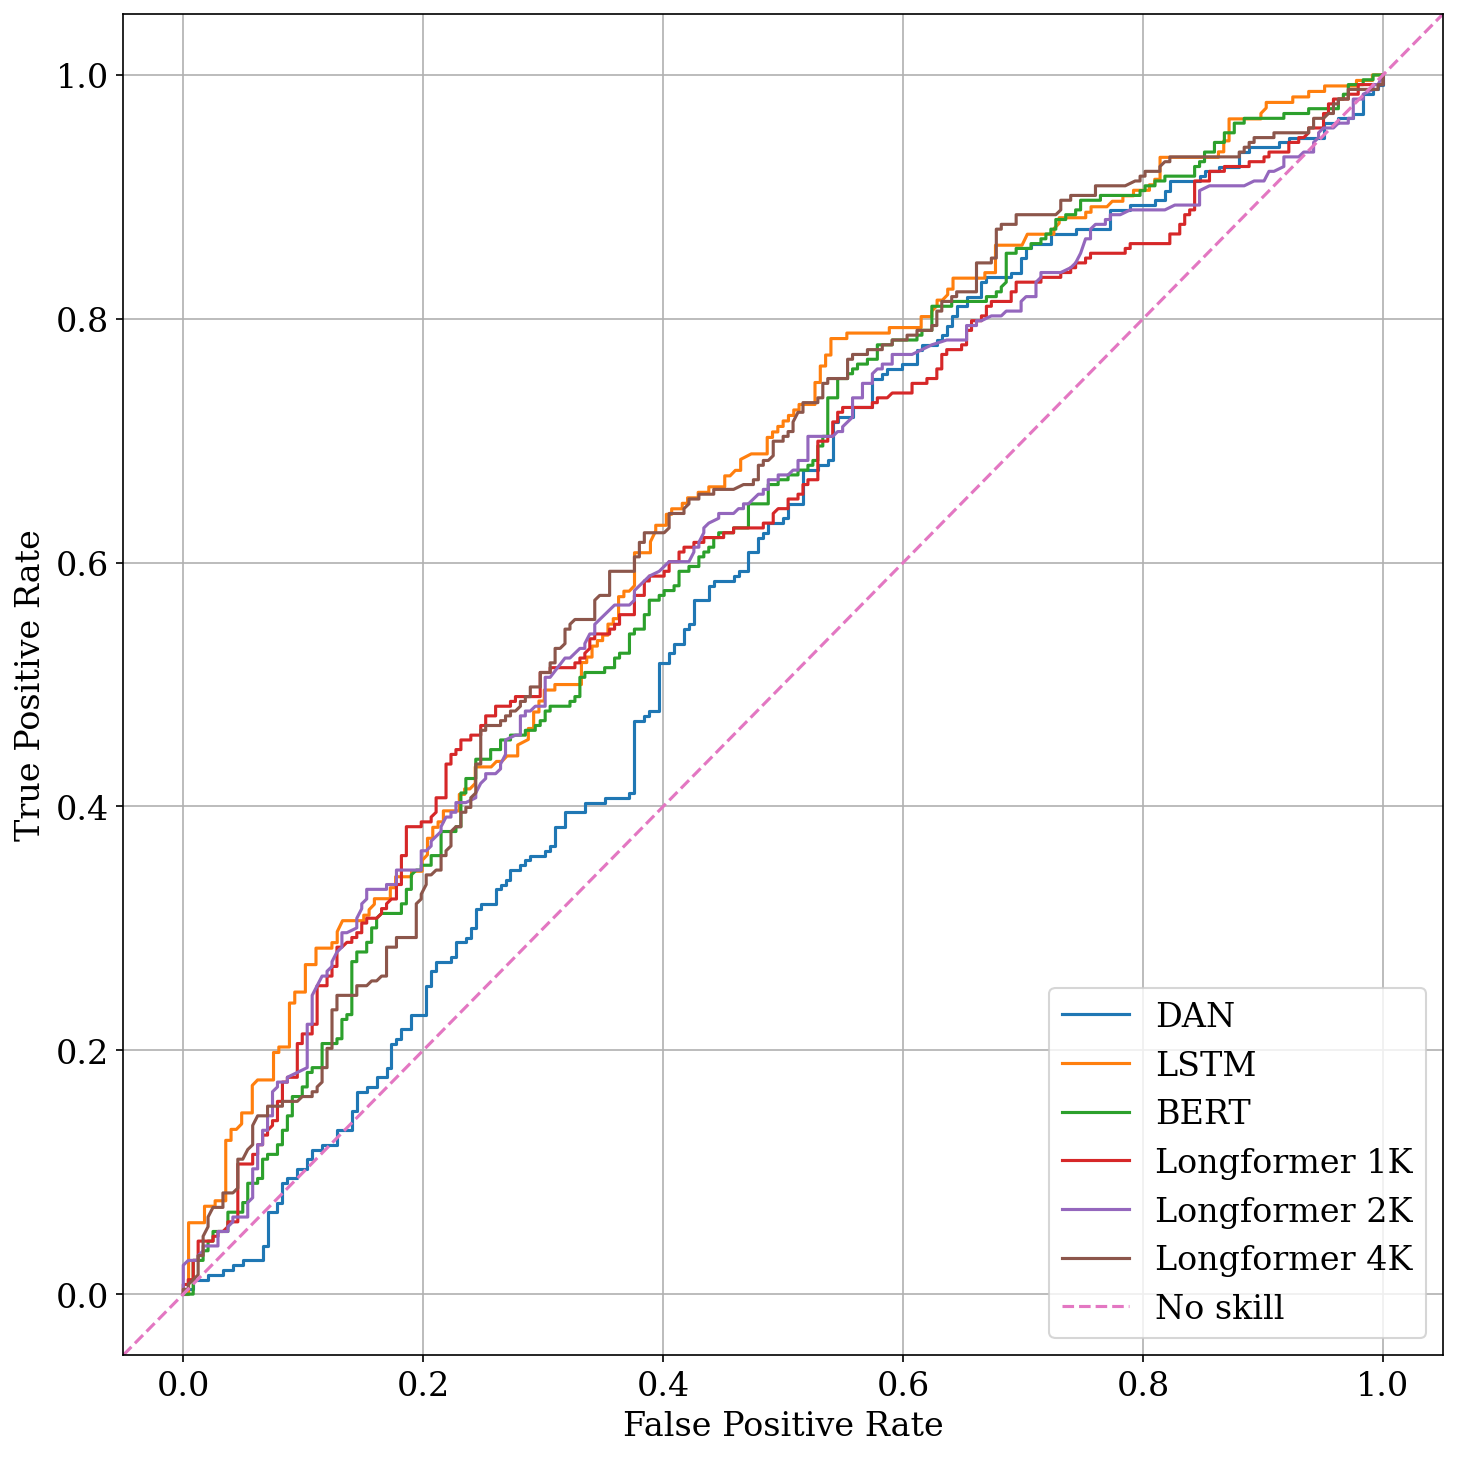

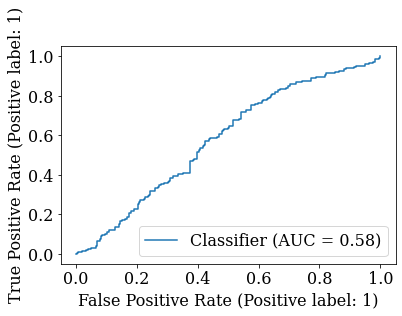

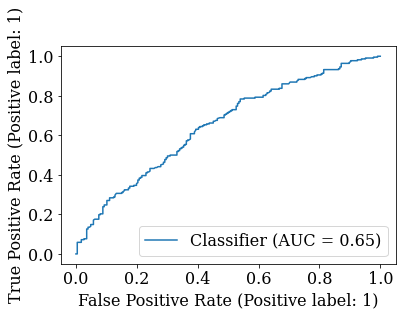

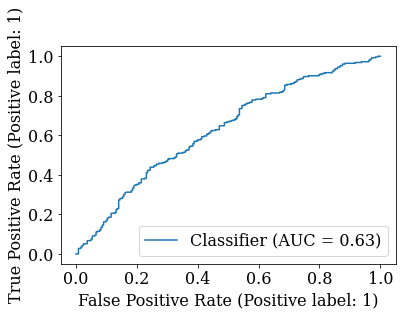

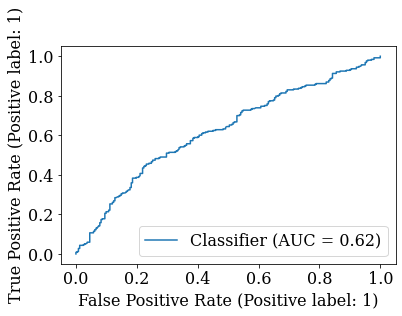

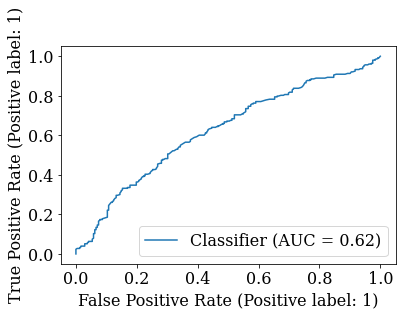

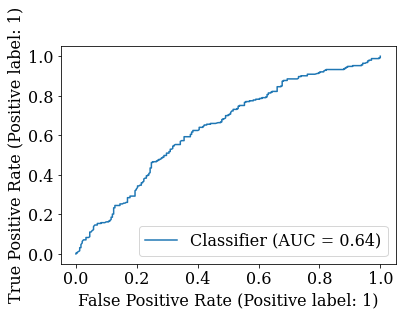

In [7]:
plt.rc('font', size=16, family=["Serif", "Palatino"])

df = dfs[0][1]
positives = len(df[df["target"] == 1]) / len(df)

fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
for (name, df) in dfs:
    display = RocCurveDisplay.from_predictions(df.target, df.p_readmit)
    display.plot(ax=ax, name=f"{name}", drawstyle="default", label=f"{name}")

ax.plot([0, 1], [0, 1], linestyle='--', label="No skill", transform=ax.transAxes)
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax.legend(loc="lower right")
ax.grid(True)
fig.tight_layout()

# Hyperparameter tuning

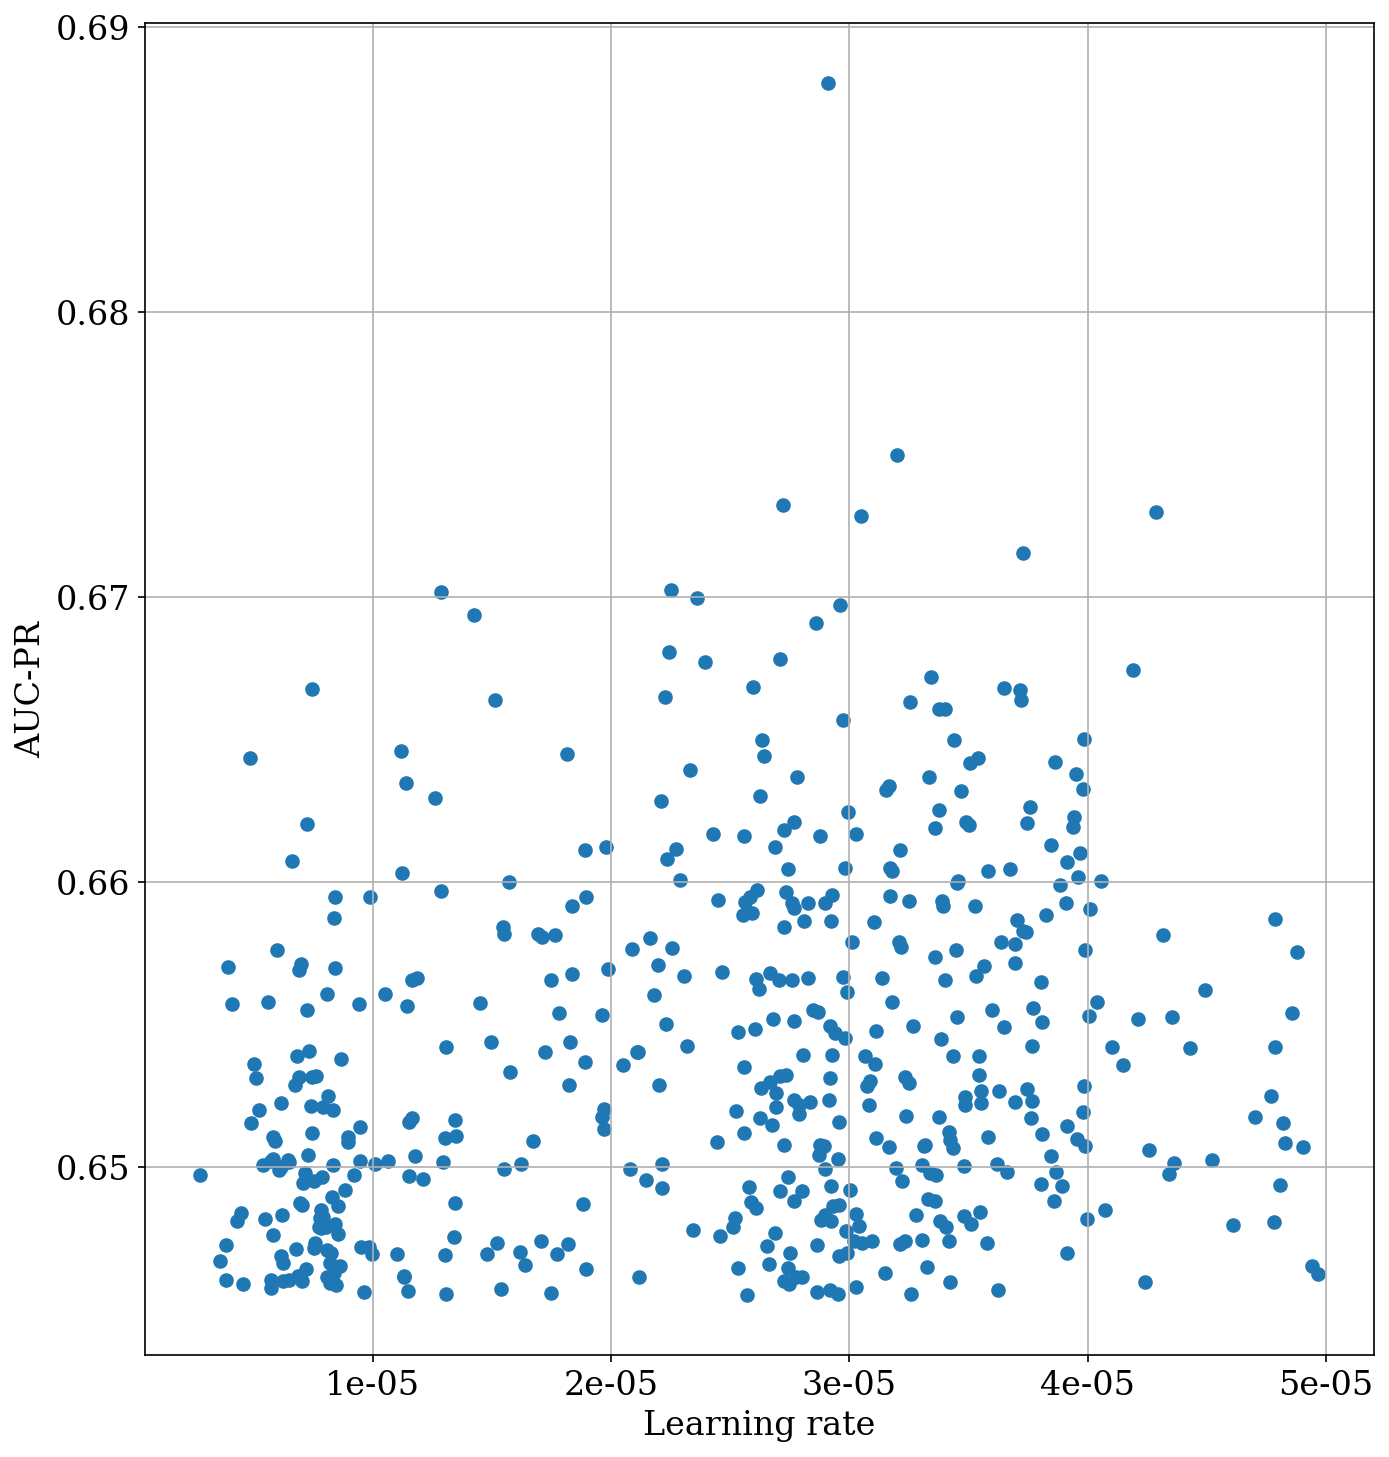

In [8]:
plt.rc('font', size=16, family=["Serif", "Palatino"])
df = pd.read_csv("/home/yassin/Downloads/wandb_export_2022-05-27T17 28 11.680+02 00.csv")
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
ax.scatter(df["lr"], df["AVG-Precision/valid"])
ax.set(xlabel="Learning rate", ylabel="AUC-PR")
ax.grid(True)
ax.xaxis.set_major_formatter(tick.FormatStrFormatter("%.0e"))
fig.tight_layout()
fig.subplots_adjust(right=0.93)


# Longformer-4096


## Positive class


In [9]:
pos = df_longf_4096[df_longf_4096["target"] == 1]
diff = (pos.target - pos.p_readmit).abs().sort_values()
top_10 = diff[:10].index
bottom_10 = diff[-10:].index

### Best


In [10]:
best = df_longf_4096.iloc[top_10[4]]

In [11]:
f"HADM_ID={best.hadm_id} PRED={best.p_readmit} TARGET={best.target}"

'HADM_ID=113189.0 PRED=0.84521484375 TARGET=1.0'

In [12]:
best.tokenized[:TEXT_SIZE]

"[CLS] date of birth : sex : f service : medicine all ##er ##gies : pen ##ici ##llins / per ##co ##ce ##t attending : chief complaint : hyper ##tens ##ive urgency major surgical or invasive procedure : hem ##od ##ial ##ysis history of present illness : from admission note : the pt is a 24 y . o . f with es ##rd on hd , sl ##e , mali ##gnant h ##t ##n , history of sv ##c syndrome admitted with h ##t ##n and sob in the setting of missed hd . the patient reported missing hd yesterday because she thinks she is being over ##di ##ures ##ed . she reports persistent pain at site of rec ##tus sheath hem ##ato ##ma . denies n / v / d . pt recently admitted from with consistent abdominal pain at the site of her known left abdominal wall hem ##ato ##ma , hyper ##tens ##ive to 230 ' s and hyper ##kal ##"

In [13]:
best_lstm = df_lstm.iloc[df_lstm.index[df_lstm["hadm_id"] == best.hadm_id][0]]

In [14]:
f"HADM_ID={best_lstm.hadm_id} PRED={best_lstm.p_readmit} TARGET={best_lstm.target}"

'HADM_ID=113189 PRED=0.935546875 TARGET=1.0'

In [28]:
best_lstm.text[:TEXT_SIZE]

"date of birth sex f service medicine allergies penicillins / percocet attending chief complaint hypertensive urgency major surgical or invasive procedure hemodialysis history of present illness from admission note the pt is a 24 y . o . f with esrd on hd , sle , malignant htn , history of svc syndrome admitted with htn and sob in the setting of missed hd . the patient reported missing hd yesterday because she thinks she is being overdiuresed . she reports persistent pain at site of rectus sheath hematoma . denies n/v/d . pt recently admitted from with consistent abdominal pain at the site of her known left abdominal wall hematoma , hypertensive to 230 ' s and hyperkalemic to 2 after missing her last two dialysis sessions . at this time the pt . was dialyzed , received a blood transfusion ,"

### Worst


In [60]:
worst = df_longf_4096.iloc[bottom_10[9]]

In [51]:
f"HADM_ID={worst.hadm_id} PRED={worst.p_readmit} TARGET={worst.target}"

'HADM_ID=114114.0 PRED=0.11474609375 TARGET=1.0'

In [52]:
worst.tokenized[:TEXT_SIZE]

'[CLS] date of birth : sex : m service : medicine all ##er ##gies : patient recorded as having no known all ##er ##gies to drugs attending : chief complaint : suicide attempt , et ##oh withdrawal major surgical or invasive procedure : none history of present illness : mr . is a 60 year old male with a history of depression , anxiety , substance use , hc ##v , and prior suicide attempts who presents with alcohol withdrawal after a suicide attempt earlier today . he ran out of his psychiatric medications two weeks ago and has felt increasingly suicidal since . he attempted to hang himself with a belt from the ceiling and after kicking the chair out from under himself the ceiling fell and he landed on the ground . he then called a cab to bring him to the ed . he normally drinks a qu ##art to a'

In [53]:
worst_lstm = df_lstm.iloc[df_lstm.index[df_lstm["hadm_id"] == worst.hadm_id][0]]

In [54]:
f"HADM_ID={worst_lstm.hadm_id} PRED={worst_lstm.p_readmit} TARGET={worst_lstm.target}"

'HADM_ID=114114 PRED=0.52880859375 TARGET=1.0'

In [55]:
worst_lstm.text

"date of birth sex m service medicine allergies patient recorded as having no known allergies to drugs attending chief complaint suicide attempt , etoh withdrawal major surgical or invasive procedure none history of present illness mr . is a 60 year old male with a history of depression , anxiety , substance use , hcv , and prior suicide attempts who presents with alcohol withdrawal after a suicide attempt earlier today . he ran out of his psychiatric medications two weeks ago and has felt increasingly suicidal since . he attempted to hang himself with a belt from the ceiling and after kicking the chair out from under himself the ceiling fell and he landed on the ground . he then called a cab to bring him to the ed . he normally drinks a quart to a half gallon of liquor . he drank about a quart this morning . he endorses prior history of dts and seizures with alcohol withdrawal . . in the ed , initial vs were pain 0 , t 8 , hr 97 , bp 180/111 , rr 22 , o2 sat 98% ra . he was noted to h

In [56]:
stylecloud.gen_stylecloud(worst_lstm.text, icon_name="fas fa-square")

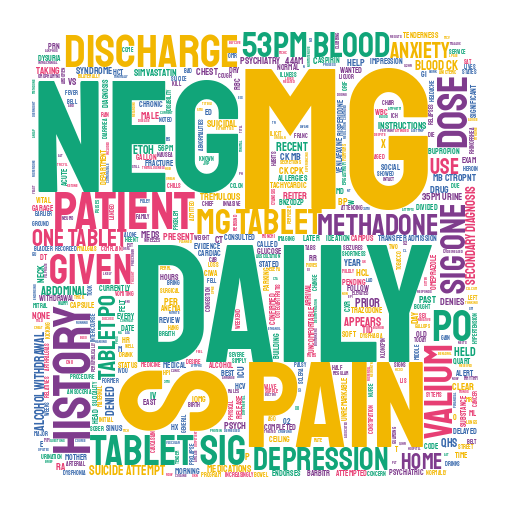

In [57]:
from IPython.display import Image
Image(filename='stylecloud.png') 